In [1]:
def prior_finder(d):
    sections = {}

    def recurse(path, current):
        if not isinstance(current, Mapping):
            return
        if "prior" in current:
            sections[".".join(path)] = current
        for k, v in current.items():  # preserves order
            if isinstance(v, Mapping):
                recurse(path + (k,), v)

    recurse((), d)
    
    return sections

In [2]:
def clean_dictionary(data, key_to_remove):
    if isinstance(data, dict):
        keys_to_check = list(data.keys())
        for key in keys_to_check:
                if key.endswith(key_to_remove):
                    del data[key]
                else:
                    data[key] = clean_dictionary(data[key], key_to_remove)
    elif isinstance(data, list):
        for i, item in enumerate(data):
            data[i] = clean_dictionary(item, key_to_remove)
    return data

In [ ]:
# pip install virga-exo==2.0
# will update to this later...
# brewster & some other options don't seem to be working
# none of clouds seem to be working...

In [3]:
path_to_opacity_DB = '/Users/sjanson/Desktop/code/picaso/reference/opacities/opacities.db'
path_to_virga_mieff = '/Users/sjanson/Desktop/code/picaso/reference/virga/'

# if you have to manually specify paths for env vars, change below; else comment out the os.environ commands below
picaso_refdata_env_var = "/Users/sjanson/Desktop/code/picaso/reference"
pysyn_cdbs_env_var = '/Users/sjanson/Desktop/code/picaso/reference/grp/redcat/trds'
import os
os.environ['picaso_refdata'] = picaso_refdata_env_var
os.environ['PYSYN_CDBS'] = pysyn_cdbs_env_var

import numpy as np
from scipy import stats
import tomllib 
import copy 
# from picaso import Parameterize
# import picaso as go

from picaso.parameterizations import Parameterize
import picaso.driver as go
import matplotlib.pyplot as plt
from picaso import justdoit as jdi 
from bokeh.plotting import figure, show
import bokeh.palettes as pals
from bokeh.models import Legend
from bokeh.io import output_notebook
import random
from picaso import justplotit as jpi



/Users/sjanson/Desktop/code/.venv/lib/python3.13/site-packages/picaso/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import declare_namespace


In [5]:
output_notebook()


Loading BokehJS ...

In [4]:
def write_to_guess_toml(dictionary, keys, value):
    stopIndex = -1
    if keys[-1].isdigit():
        stopIndex = -2
    for key in keys[:stopIndex]:
        dictionary = dictionary[key]

    if keys[-1].isdigit(): # to handle lists
        dictionary[keys[-2]][int(keys[-1])] = value
    else:
        dictionary[keys[-1]] = value

In [ ]:
"""
cleanup process:
- make sure it works with all inputs
- clouds has divide by zero issues `._.<
    - and probably does not include all inputs
- some things in chemistry have to stay constant
- some things in temperature have to stay integers
- cleanup and modularize, see if there's anywhere to optimize
- make sure all axes flipped
- p much it
- why is temperature.pressure not getting removed 
should figure out today with Katie if I need to turn my stuff in or not...
"""

"\ncleanup process:\n- make sure it works with all inputs\n- clouds has divide by zero issues `._.<\n    - and probably does not include all inputs\n- some things in chemistry have to stay constant\n- some things in temperature have to stay integers\n- cleanup and modularize, see if there's anywhere to optimize\n- make sure all axes flipped\n- p much it\nshould figure out today with Katie if I need to turn my stuff in or not...\n"

In [6]:
def hypercube(u, fitpars):
    x=np.empty(len(u))

    for i,key in enumerate(fitpars.keys()):
        if fitpars[key]['prior'] == 'uniform':
            minn=fitpars[key]['uniform_kwargs']['min']
            maxx=fitpars[key]['uniform_kwargs']['max']
            x[i] = minn+(maxx-minn)*u[i]
        elif fitpars[key]['prior'] == 'gaussian':
            mean=fitpars[key]['gaussian_kwargs']['mean']
            std=fitpars[key]['gaussian_kwargs']['std']
            x[i]=stats.norm.ppf(u[i], loc=mean, scale=std)
        else:
            raise Exception('Prior type not available')
        if fitpars[key]['log']:
            x[i]=10**x[i]  
    return x

In [7]:
MASTER_CONSTRUCTED_TOML= None
MASTER_CONSTRUCTED_TOML_PATH = '/Users/sjanson/Desktop/code/picaso/reference/input_tomls/driver.toml'
if isinstance(MASTER_CONSTRUCTED_TOML_PATH, str):
    with open(MASTER_CONSTRUCTED_TOML_PATH, "rb") as f:
        MASTER_CONSTRUCTED_TOML = tomllib.load(f)
else:
    print('Cannot find driver.toml file')


In [8]:
selected_items = {}
def list_available_free_parameters(data, current_path=""):
    for key, value in data.items():
        new_path = f"{current_path}.{key}" if current_path else key

        if isinstance(value, dict):
            list_available_free_parameters(value, new_path)
        elif isinstance(value, float):
            selected_items[new_path] = value
        elif isinstance(value, int) and not isinstance(value, bool):
            selected_items[new_path] = value
list_available_free_parameters(MASTER_CONSTRUCTED_TOML)
example = {}
for key,value in selected_items.items():
    if 'nlevel' not in key: # not 'chemistry' in key 
        example[key] = dict(
            prior='uniform',
            uniform_kwargs=dict(min=value*0.75, max=value*1.25),
            log=False
        )
import pprint
pp = pprint.PrettyPrinter(indent=3)
# pp.pprint(example)


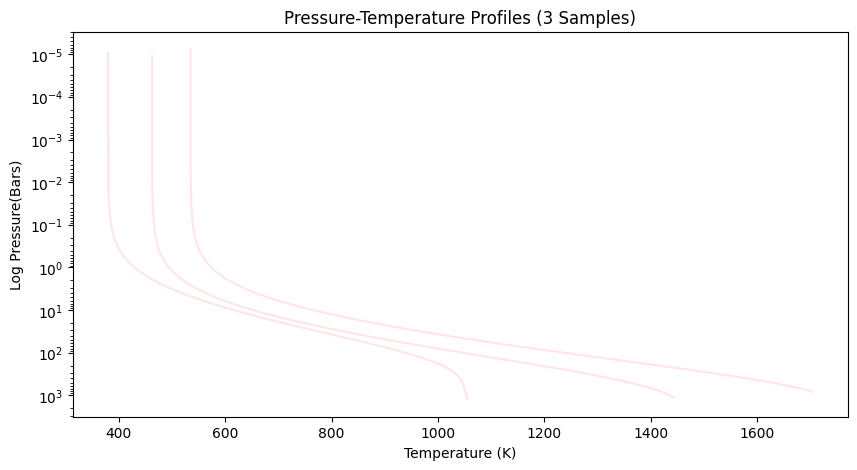

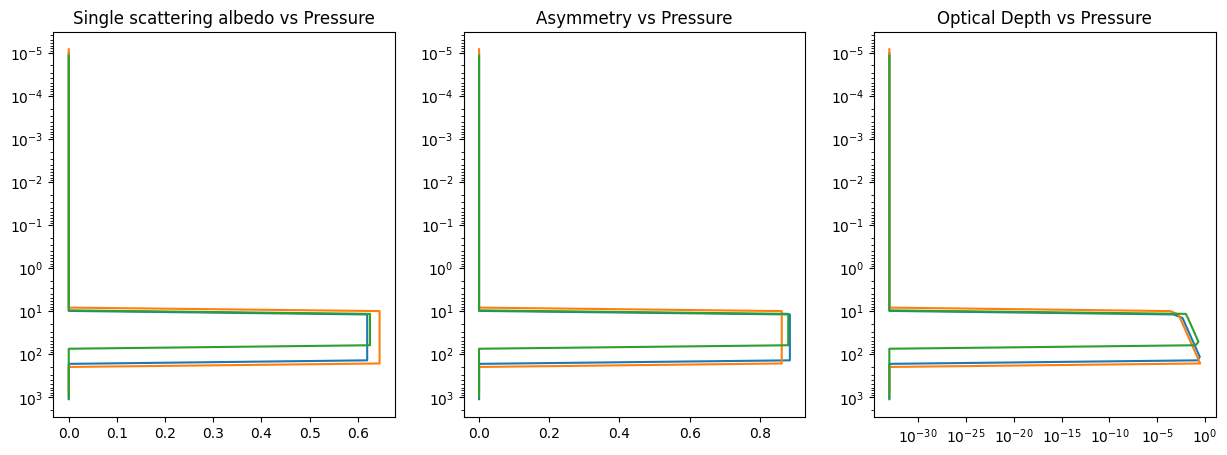

In [57]:
# example = {
opacity = None
param_tools = None
#         'temperature.guillot.logg1': dict(
#             prior='uniform',
#             uniform_kwargs=dict(min=-2, max=2),
#             log=False
#         ),
#         'temperature.guillot.logKir': dict(
#             prior='uniform',
#             uniform_kwargs=dict(min=-2, max=2),
#             log=False
#         ),
#         'chemistry.free.H2O.value': dict(
#             prior='uniform',
#             uniform_kwargs=dict(min=0,max=0.5),
#             log=False
#         ), 
#         'chemistry.free.TiO.value': dict(
#             prior='uniform',
#             uniform_kwargs=dict(min=0,max=0.5),
#             log=False
#         ), 
#         # # each value has to be greater than the next
#         'chemistry.free.CH4.values.0': dict(
#             prior='uniform',
#             uniform_kwargs=dict(min=0,max=0.25),
#             log=False
#         ),
#         'chemistry.free.CH4.values.1': dict(
#             prior='uniform',
#             uniform_kwargs=dict(min=0.25,max=0.5),
#             log=False
#         ),

#         'clouds.cloud1.virga.fsed': dict(
#             prior='uniform',
#             uniform_kwargs=dict(min=0.25,max=15),
#             log=False
#         ),
#         'clouds.cloud1.virga.sig': dict(
#             prior='uniform',
#             uniform_kwargs=dict(min=1,max=3),
#             log=False
#         ),
# }
    #     mean molecular weight
    #     'clouds.cloud1.virga.mmw': dict(
    #         prior='uniform',
    #         uniform_kwargs=dict(min=1,max=3),
    #         log=False
    #     ),
    #     'temperature.guillot.alpha': dict(
    #         prior='uniform',
    #         uniform_kwargs=dict(min=0.25, max=0.75),
    #         log=False), 
    #     'temperature.isothermal.T': dict(
    #     prior='uniform',
    #     uniform_kwargs=dict(min=1000, max=1500), log=False),
    # }

# ensure it works with all inputs & types...

nsamples = 3 # 50

# save_all_class = {}
ALL_TOMLS = []
save_all_class_pt = []

save_data_class = None
for i in range(nsamples):
    #1- get randomly generated values for everything in your chemistry set (here that is CH4 and H2O )
    check_all_values = hypercube(np.random.rand(len(example.keys())), example)
    GUESS_TOML = copy.deepcopy(MASTER_CONSTRUCTED_TOML)

    for index, free_parameter in enumerate(example.keys()):
        sampled_value = check_all_values[index]
        # split free_parameters into path to put back into GUESS_TOML
        keys = free_parameter.split('.')
        write_to_guess_toml(GUESS_TOML, keys, sampled_value)

    opacity = jdi.opannection(
        filename_db=GUESS_TOML['OpticalProperties']['opacity_files'], #database(s)
        method=GUESS_TOML['OpticalProperties']['opacity_method'], #resampled, preweighted, resortrebin
        **GUESS_TOML['OpticalProperties']['opacity_kwargs'] #additonal inputs 
    )
    param_tools = Parameterize(load_cld_optical=go.find_values_for_key(GUESS_TOML ,'condensate'), mieff_dir=GUESS_TOML['OpticalProperties'].get('virga_mieff', None))
#     save_all_class[i]=setup_class(GUESS_TOML, stage='clouds')
    ALL_TOMLS.append(GUESS_TOML)
    
    data_class = go.setup_spectrum_class(clean_dictionary(GUESS_TOML, '_options'), opacity, param_tools)
    save_data_class = data_class
    t = data_class.inputs['atmosphere']['profile']['temperature']
    p = data_class.inputs['atmosphere']['profile']['pressure']
    cloud_profile = data_class.inputs['clouds']['profile']
    mixingratios = data_class.inputs['atmosphere']['profile']
    for key in mixingratios.keys():
        if key != 'pressure' or key != 'temperature':
            mixingratios[key] = mixingratios[key]
    

    limit = 50
    molecules = [mol for mol in mixingratios.keys() if mol not in ['pressure', 'temperature', 'kz']][:limit]
    save_all_class_pt.append({
        'temperature':t,
        'pressure':p,
        'mixingratios':mixingratios,
        'molecules': molecules,
        'cloudprofile': cloud_profile
    })


kwargs = {}
kwargs['y_axis_label'] = kwargs.get('y_axis_label','Pressure(Bars)')
kwargs['x_axis_label'] = kwargs.get('x_axis_label','Mixing Ratio(v/v)')
kwargs['y_axis_type'] = kwargs.get('y_axis_type','log')
kwargs['x_axis_type'] = kwargs.get('x_axis_type','log') 

# #3 - create your plots again 
bokeh_fig = figure(**kwargs)
cols = pals.magma(min([len(molecules),limit]))
legend_it=[]

moles = {mol:[] for mol in molecules}
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(10,5))
# need to modularize and convert from matplotlib to bokeh
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

for i in range(nsamples):
    pressure = save_all_class_pt[i]['pressure']
    temperature = save_all_class_pt[i]['temperature']
    mixingratios = save_all_class_pt[i]['mixingratios']
    axes.semilogy(temperature,pressure, color='red', alpha=0.1)
    cloud_df = save_all_class_pt[i]['cloudprofile']
    cloud_pressure = cloud_df['pressure']
    wavenumber = cloud_df['wavenumber'].unique()

    nwno = len(wavenumber)
    cloud_pressure = cloud_df['pressure'].unique()
    nlayer = len(cloud_df['pressure'].unique())

    w0 = np.reshape(cloud_df['w0'].values,(nlayer,nwno))
    opd = np.reshape(cloud_df['opd'].values,(nlayer,nwno)) + 1e-60
    g0 = np.reshape(cloud_df['g0'].values,(nlayer,nwno))

    ssa1d = np.mean(w0,axis=1) # ssa [nlayer, nwavelength]
    g01d = np.mean(g0,axis=1)
    opd1d = np.mean(opd,axis=1)

    ax1.semilogy(ssa1d, cloud_pressure)
    # ax1.set_xlim([0,1])
    ax1.invert_yaxis()
    ax1.set_title("Single scattering albedo vs Pressure")
    ax2.semilogy(g01d, cloud_pressure)
    # ax2.set_xlim([0,1])
    ax2.invert_yaxis()
    ax2.set_title("Asymmetry vs Pressure")
    ax3.loglog(opd1d, cloud_pressure)
    # ax3.set_xlim([1e-5,50])
    ax3.set_title("Optical Depth vs Pressure")
    ax3.invert_yaxis()

    for mol, c in zip(molecules, cols):
        # this needs to not be inside this for loop
        f = bokeh_fig.line(mixingratios[mol],pressure, color=c, line_width=2,
            muted_color=c, muted_alpha=0.05, line_alpha=0.5)
        moles[mol].append(f)
for mol in moles.keys():
    legend_it.append((mol, moles[mol]))
legend = Legend(items=legend_it, location=(0, -20))
legend.click_policy="mute"
bokeh_fig.add_layout(legend, 'left')
bokeh_fig.y_range.flipped = True
show(bokeh_fig)
# make units accurate to what in driver.toml
axes.set_xlabel("Temperature (K)") 
axes.set_ylabel("Log Pressure(Bars)")
axes.set_title(f"Pressure-Temperature Profiles ({nsamples} Samples)")
axes.invert_yaxis()
axes.set_yscale('log')
plt.show()


In [10]:
WNO_LIST = []
ALB_LIST = []
for toml in ALL_TOMLS:
    print(toml)
    cleaned = clean_dictionary(toml, '_options')
    x_range = [0,15]
    spectral_resolution = 150

    df = go.run(driver_dict=cleaned)
    obs_key = 'thermal' if toml['observation_type'] == 'thermal' else 'albedo'
    wno, alb, fpfs, full = df['wavenumber'] , df[obs_key] , df[f'fpfs_{toml['observation_type']}'], df['full_output']
    wno, alb = jdi.mean_regrid(wno, alb, R=spectral_resolution)
    WNO_LIST.append(wno)
    ALB_LIST.append(alb)

jpi.show(jpi.spectrum(WNO_LIST, ALB_LIST, palette=[(255,0,0,0.3)], plot_width=500,x_range=x_range))

{'observation_type': 'thermal', 'irradiated': False, 'calc_type': 'spectrum', 'InputOutput': {'observation_data': ['/Users/sjanson/Desktop/code/picaso/docs/notebooks/D_climate/spectra_logzz_9.0_teff_400.0_grav_1000.0_mh_0.0_co_1.0.nc'], 'retrieval_output': '/Users/sjanson/Desktop/code/picaso/docs/notebooks/J_driver_WIP/output', 'spectrum_output': '/Users/sjanson/Desktop/code/picaso/docs/notebooks/J_driver_WIP/output'}, 'OpticalProperties': {'opacity_files': '/Users/sjanson/Desktop/code/picaso/reference/opacities/opacities.db', 'opacity_method': 'resampled', 'opacity_kwargs': {}, 'virga_mieff': '/Users/sjanson/Desktop/code/picaso/reference/virga/'}, 'object': {'radius': {'value': 0.9688370958253306, 'unit': 'Rjup'}, 'mass': {'value': 1.213120842028055, 'unit': 'Mjup'}, 'gravity': {'value': 105789.6656887467, 'unit': 'cm/s**2'}, 'distance': {'value': 6.42269112023485, 'unit': 'parsec'}, 'teff': {'value': 5146.300631140838, 'unit': 'Kelvin'}, 'teq': {'value': 413.2925487564143, 'unit': 'K

In [9]:
# make pt in bokeh
# custom cloud figure to display the priors
# verify that the new cloud methodology jpi.plot_cld_input
# verify that there's not multiple things being run

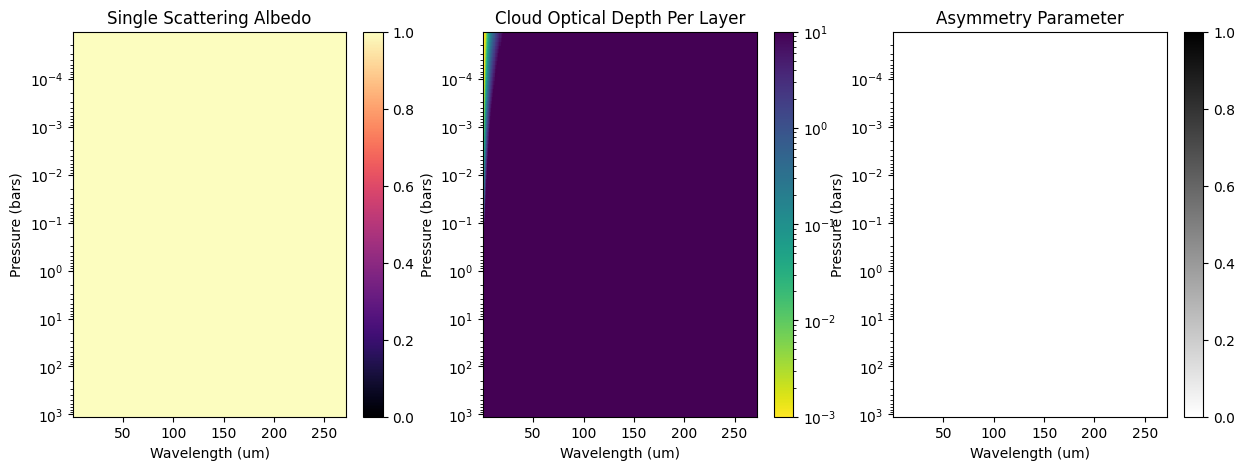

In [ ]:

data_class_toml2 = clean_dictionary(ALL_TOMLS[0], '_options')

data_class_toml = copy.deepcopy(data_class_toml2)
# print((data_class_toml['clouds']['cloud1']['brewster_mie']))
data_class_toml['clouds']['cloud1_type'] = 'brewster_mie'
# data_class_toml['clouds']['cloud1']['hard_grey'] = {key:float(val) for key,val in data_class_toml['clouds']['cloud1']['hard_grey'].items()}

# data_class_toml['clouds']['cloud1']['hard_grey'] = dict(
#     p = 5.0, # {value=1,unit='logbar'} #bottom pressure
#     dp = 5, # {value=1,unit='logbar'} #thickness in log 
#     w0 = 5, #single scattering albedo
#     g0 = 5, #asymmetry
#     opd = 100
# )
# print((data_class_toml['clouds']['cloud1']['hard_grey']))

# print(data_class_toml['clouds'])
# print(data_class_toml['clouds'])
data_class = go.setup_spectrum_class(data_class_toml, opacity, param_tools)
df = data_class.inputs['clouds']['profile'].astype('float')
# use set instead of unique keep ordering
# unique wavenumber
# use cloud/other function reshaping
# validate clouds
# # np.flip(np.reshape[dat01['w0]]) in plot_cld_inputs()

nwno = len(df['wavenumber'].unique())
nlayer = len(df['pressure'].unique())

wavenumber_unique = df['wavenumber'].unique()
pressure_unique = df['pressure'].unique()
# wavenumber_unique = df.iloc[0:nwno,:]['wavenumber'].values
# pressure_unique = df.iloc[::nwno,:]['pressure'].values

wavelength_unique = 1e4/wavenumber_unique
bokeh_plot = jpi.plot_cld_input(nwno, nlayer, df=df,pressure=pressure_unique, wavelength=wavelength_unique)


In [ ]:
# jdi.jupiter_cld() 2_addingclouds.ipynb

In [11]:
     # matplotlib     
     # hex_colors = {mol:'#{:06x}'.format(random.randint(0, 0xFFFFFF)) for mol in molecules}
   
# for i in range(nsamples):
#     for mol in save_all_class_pt[i]['molecules']:
#         axes[0].semilogy(temperature, 
#                 pressure, color='red', alpha=0.04)
#         # axes[1].plot(save_all_class_pt[i]['mixingratios'][mol], save_all_class_pt[i]['pressure'], label=mol, color=hex_colors[mol], alpha=0.1)

# # make units accurate to what in driver.toml
# axes[0].set_xlabel("Temperature (K)") 
# axes[0].set_ylabel("Log Pressure(Bars)")
# axes[0].set_title(f"Pressure-Temperature Profiles ({nsamples} Samples)")
# axes[0].invert_yaxis()
# axes[0].set_yscale('log')

# # remove duplicate labels for legend
# handles, labels = plt.gca().get_legend_handles_labels()
# unique = dict(zip(labels, handles))
# # axes[1].legend(unique.values(), unique.keys())

# # plot settings
# # axes[1].invert_yaxis()
# # axes[1].set_ylim(np.max(save_all_class_pt[i]['pressure']), np.min(save_all_class_pt[i]['pressure']))
# # axes[1].set_xlabel("Log Mixing Ratios [v/v]")
# # axes[1].set_ylabel("Log Pressure")
# # axes[1].set_title(f"Mixing Ratios ({nsamples} Samples)")
# # axes[1].set_yscale('log')
# # axes[1].set_xscale('log')
# plt.show()